# 06. FermatKDE y FermatKDClassifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, DensityMixin
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.neighbors import KernelDensity
from sklearn.datasets import (
    load_iris,
    load_digits,
    make_moons,
    fetch_openml,
    make_circles,
)
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

from joblib import Memory


cachedir = "_cache"
memory = Memory(cachedir, verbose=100)


@memory.cache
def euclidean(X, Y=None):
    if Y is None:
        return squareform(pdist(X, metric="euclidean"))
    else:
        return cdist(X, Y, metric="euclidean")


@memory.cache
def sample_fermat(Q, alpha=1):
    return shortest_path(csr_matrix(euclidean(Q) ** alpha), directed=False)


class Bundle(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)

    def __setattr__(self, key, value):
        self[key] = value

In [2]:
def iqr(X):
    return np.percentile(X, 75) - np.percentile(X, 25)
    
    
def pilot_h(dists):
    return 0.9 * np.minimum(dists.std(), iqr(dists) / 1.34) * len(dists) ** (-1 / 5)
    # return np.mean(sample_fermat(X, alpha=alpha))

In [3]:
isosceles = np.array([[0, 0], [3 / 2, np.sqrt(7 / 4)], [-3 / 2, np.sqrt(7 / 4)]])

In [4]:
euc = euclidean(isosceles)

[Memory]0.0s, 0.0min    : Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/7a9f0ebdf6452690331f163529fee227
___________________________________________euclidean cache loaded - 0.0s, 0.0min


In [5]:
print(sample_fermat(isosceles, alpha=1), sample_fermat(isosceles, alpha=2), sep="\n")

[Memory]0.0s, 0.0min    : Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/9be614e853db95b769d95dccffe94e96
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/dc93f908c3b8ac121c3b12c092c7a494
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[[0. 2. 2.]
 [2. 0. 3.]
 [2. 3. 0.]]
[[0. 4. 4.]
 [4. 0. 8.]
 [4. 8. 0.]]


In [6]:
class FermatKDE(BaseEstimator, DensityMixin):
    # MAX_DIST = 38.6
    MIN_LOG_SCORE = -1e6

    def __init__(self, alpha=1, bandwidth=1, d=None):
        self.bandwidth = bandwidth
        self.alpha = alpha
        self.d = d  # TODO: Evitar completamente? Quitando el h^-d del score?

    def fit(self, X):
        self.Q_ = X
        # A is the adjacency matrix with Fermat distances as edge weights
        self.A_ = sample_fermat(X, self.alpha)
        if self.d is None:
            self.d = self.D
        return self

    @property
    def N(self):
        return self.Q_.shape[0]

    @property
    def D(self):
        return self.Q_.shape[1]

    def _sample_distances(self, X):
        to_Q = euclidean(X, self.Q_) ** self.alpha
        sample_distances = np.zeros((X.shape[0], self.N))
        for i in range(len(X)):
            sample_distances[i, :] = np.min(to_Q[i].T + self.A_, axis=1)
        return sample_distances

    def score_samples(self, X=None, log=True):
        if X is None:
            X = self.Q_

        score = np.exp(-0.5 * (self._sample_distances(X) / self.bandwidth) ** 2).sum(1)

        if log:
            return (
                -np.log(self.N)
                - self.d * np.log(self.bandwidth)
                - self.d / 2 * np.log(2 * np.pi)
                + np.maximum(np.log(score), self.MIN_LOG_SCORE)
            )

        else:
            return (
                self.N**-1
                * (self.bandwidth**-self.d)
                * (2 * np.pi) ** (-self.d / 2)
                * score
            )

    def score(self, X=None):
        if X is None:
            X = self.Q_
        return self.score_samples(X).sum()

In [7]:
from fermat import Fermat


class OOSFermatKDE:
    def __init__(self, alpha=1, bandwidth=1):
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.euclidean_dists_ = euclidean(X)
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            self.euclidean_dists_
        )
        self.fermat_dists_ = self.fermat_.get_distances()
        self.n_, self.dim_ = X.shape
        return self

    def _dist_to_edge(self, X_from):
        return np.array(
            [
                [((x_from - x_to) ** 2).sum() ** (self.alpha / 2) for x_to in self.X_]
                for x_from in X_from
            ]
        )

    def _distances(self, X_from):
        to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, x_from in enumerate(X_from):
            dists[i, :] = np.min(to_edge[i].T + self.fermat_dists_, axis=1)
        return dists

    def density(self, X, log=True):
        densities = (
            (self.bandwidth**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self._distances(X) / self.bandwidth) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities

In [8]:
# X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X, y = make_moons(n_samples=4000, noise=0.1)
# X, y = load_digits(return_X_y=True)
# X, y = load_iris(return_X_y=True)
# X, y = fetch_openml(
#     "mnist_784", version=1, parser="auto", return_X_y=True, as_frame=False
# )

In [9]:
X.shape, np.unique(y)

((4000, 2), array([0, 1]))

In [10]:
y = y.astype(int)
np.unique(y)

array([0, 1])

In [11]:
pd.Series(y).value_counts()

0    2000
1    2000
dtype: int64

In [12]:
X0 = X[y == 0]#[:1000]
X1 = X[y == 1]
# X2 = X[y == 2][:500]
# X0 = X[y == 0][1000:1100,]
X.shape

(4000, 2)

In [13]:
# pixels = X[0].reshape(28, 28)
# print(pixels[15:20, 15:20])
# plt.imshow(pixels, cmap="gray")

In [14]:
seed = 2018
# Choosing train/test split by indices is equivalent to choosing rows themselves
idx_train, idx_test = train_test_split(
    np.arange(len(X0)), test_size=0.2, random_state=seed
)
tt_cv = [(idx_train, idx_test)]
ss_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=seed)

In [15]:
alpha = 1
A = sample_fermat(X0[idx_train], alpha)

________________________________________________________________________________
[Memory] Calling __main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055.sample_fermat...
sample_fermat(array([[-1.004333,  0.584776],
       ...,
       [ 0.316065,  1.062498]]), 1)
________________________________________________________________________________
[Memory] Calling __main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055.euclidean...
euclidean(array([[-1.004333,  0.584776],
       ...,
       [ 0.316065,  1.062498]]))
Persisting in _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/2ba3dd2044deb9522a5ff97e9c74d004
________________________________________________________euclidean - 0.0s, 0.0min
Persisting in _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
____________________________________________________samp

In [16]:
pilot_h(A)

0.11753709185352544

In [17]:
grid = {"bandwidth": pilot_h(A) * np.logspace(-3, 3, 61)}


In [18]:
fkde = GridSearchCV(FermatKDE(alpha=alpha), grid, cv=tt_cv, n_jobs=-1, verbose=1).fit(X0)
fdf = pd.DataFrame(fkde.cv_results_)

Fitting 1 folds for each of 61 candidates, totalling 61 fits
[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055.euclidean...
euclidean(array([[-0.304174,  0.896286],
       ...,
       [ 0.381147,  0.759791]]), array([[-1.004333,  0.584776],
       ...,
       [ 0.316065,  1.062498]]))
Persisting in _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
________________________________________________________euclidean - 0.1s, 0.0min


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min
[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min
___________________________________________euclidean cache loaded - 0

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min
[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
___________________________________________euclidean cache loaded - 0.0s, 0.0min
[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min
[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_673/1327241305.py:44: RuntimeWarning: divide by zero encountered in log


[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min
[Memory]: Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min
[Memory]: Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0

________________________________________________________________________________
[Memory] Calling __main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055.sample_fermat...
sample_fermat(array([[0.949002, 0.082007],
       ...,
       [0.865642, 0.690622]]), 1)
________________________________________________________________________________
[Memory] Calling __main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055.euclidean...
euclidean(array([[0.949002, 0.082007],
       ...,
       [0.865642, 0.690622]]))
Persisting in _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/da4e57e86eeca9b2948bb89a1c1e9832
________________________________________________________euclidean - 0.0s, 0.0min
Persisting in _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/97ee4df5f9a29320d00789aae54c573d
___________________________________________________sample_fermat

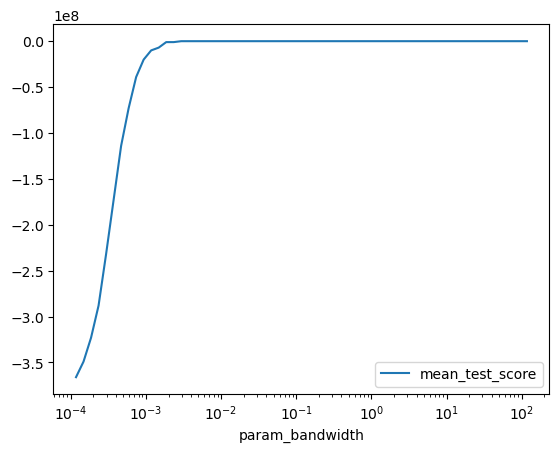

In [19]:
pd.DataFrame(fdf).plot(x="param_bandwidth", y="mean_test_score")
plt.xscale("log")

In [20]:
fdf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bandwidth,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018028,0.0,5.802066,0.0,0.000118,{'bandwidth': 0.00011753709185352545},-3.660064e+08,-3.660064e+08,0.0,61
1,0.018881,0.0,6.181064,0.0,0.000148,{'bandwidth': 0.0001479704317627884},-3.490125e+08,-3.490125e+08,0.0,60
2,0.020072,0.0,6.152011,0.0,0.000186,{'bandwidth': 0.00018628373674032915},-3.230228e+08,-3.230228e+08,0.0,59
3,0.035458,0.0,5.806562,0.0,0.000235,{'bandwidth': 0.00023451732998637493},-2.880350e+08,-2.880350e+08,0.0,58
4,0.042343,0.0,5.875087,0.0,0.000295,{'bandwidth': 0.00029523982622596567},-2.320545e+08,-2.320545e+08,0.0,57
...,...,...,...,...,...,...,...,...,...,...
56,0.019244,0.0,4.656916,0.0,46.792359,{'bandwidth': 46.79235907289358},-3.811839e+03,-3.811839e+03,0.0,41
57,0.015357,0.0,4.505462,0.0,58.90809,{'bandwidth': 58.90808991466304},-3.996004e+03,-3.996004e+03,0.0,42
58,0.022067,0.0,4.168103,0.0,74.160891,{'bandwidth': 74.16089135382508},-4.180185e+03,-4.180185e+03,0.0,43
59,0.011854,0.0,4.151653,0.0,93.363031,{'bandwidth': 93.36303068663668},-4.364375e+03,-4.364375e+03,0.0,44


In [21]:
skde = GridSearchCV(KernelDensity(), grid, cv=ss_cv, n_jobs=-1, verbose=1).fit(X0)
sdf = pd.DataFrame(skde.cv_results_)

Fitting 10 folds for each of 61 candidates, totalling 610 fits


In [22]:
fkde.best_params_, fkde.best_score_, skde.best_params_, skde.best_score_

({'bandwidth': 0.04679235907289353},
 -123.92454225949932,
 {'bandwidth': 0.04679235907289353},
 -135.73940215391949)

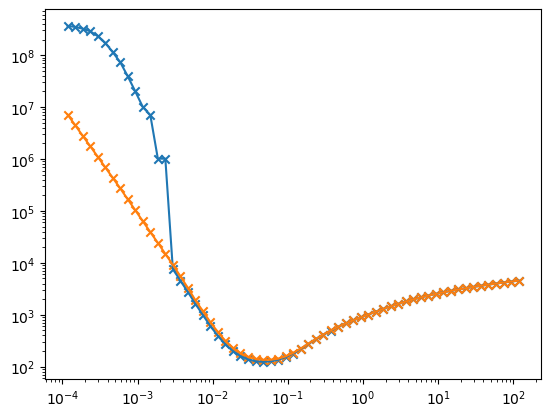

In [23]:
import seaborn as sns
for method, df in {"fermat": fdf, "sklearn": sdf}.items():
    plt.plot(df.param_bandwidth, -df.mean_test_score, label=method)
    plt.scatter(df.param_bandwidth, -df.mean_test_score, label=method, marker='x')
    # sns.lineplot(x="param_bandwidth", y="mean_test_score", label=method, data=df)#[df["param_bandwidth"].between(5, 100)])
    # sns.scatterplot(x="param_bandwidth", y="mean_test_score", label="fermat", data=df)#fdf[fdf["param_bandwidth"].between(0.3, 3)])
plt.xscale("log"), plt.yscale("log")
plt.show()

In [24]:
fkde.best_params_, fkde.best_score_, skde.best_params_, skde.best_score_

({'bandwidth': 0.04679235907289353},
 -123.92454225949932,
 {'bandwidth': 0.04679235907289353},
 -135.73940215391949)

In [25]:
# retrain fkde and skde with the best parameters from the grid search
fkde = FermatKDE(alpha=alpha, bandwidth=fkde.best_params_["bandwidth"]).fit(X0[idx_train])
skde = KernelDensity(bandwidth=skde.best_params_["bandwidth"]).fit(X0[idx_train])

[Memory]70.2s, 1.2min   : Loading sample_fermat from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/sample_fermat/330558b9015c31795f8cfa9ea994103e
_______________________________________sample_fermat cache loaded - 0.0s, 0.0min


In [26]:
fkde.score_samples(X0[idx_train]).mean(), fkde.score_samples(X0[idx_test]).mean(), fkde.score_samples(X1).mean()

________________________________________________________________________________
[Memory] Calling __main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055.euclidean...
euclidean(array([[-1.004333,  0.584776],
       ...,
       [ 0.316065,  1.062498]]), array([[-1.004333,  0.584776],
       ...,
       [ 0.316065,  1.062498]]))
Persisting in _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/03da4c7c318ed0dd124385bd167ddbeb
________________________________________________________euclidean - 0.0s, 0.0min
[Memory]78.1s, 1.3min   : Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min


________________________________________________________________________________
[Memory] Calling __main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055.euclidean...
euclidean(array([[ 2.094109,  0.170904],
       ...,
       [ 1.226615, -0.468021]]), array([[-1.004333,  0.584776],
       ...,
       [ 0.316065,  1.062498]]))
Persisting in _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/bda07ca2416a2a89b240f50b38b2f310
________________________________________________________euclidean - 0.0s, 0.0min


(-0.26074521193057754, -0.3098113556487483, -64.19090195452272)

In [27]:
skde.score_samples(X0[idx_train]).mean(), skde.score_samples(X0[idx_test]).mean(), skde.score_samples(X1).mean()

(-0.260745211930589, -0.30981135564875906, -60.7778530933392)

In [28]:
pd.Series(fkde.score_samples(X0[idx_test])).describe()

[Memory]89.9s, 1.5min   : Loading euclidean from _cache/joblib/__main__--var-folders-h3-d7vpv1m17lv29p7dw5y0yy1c0000gn-T-ipykernel-915298055/euclidean/98ab93b545e02ce1f0bd35576b46034c
___________________________________________euclidean cache loaded - 0.0s, 0.0min


count    400.000000
mean      -0.309811
std        0.613814
min       -3.519285
25%       -0.508999
50%       -0.087564
75%        0.055885
max        0.466378
dtype: float64

In [29]:
pd.Series(skde.score_samples(X0[idx_test])).describe()

count    400.000000
mean      -0.309811
std        0.613814
min       -3.519285
25%       -0.508999
50%       -0.087564
75%        0.055885
max        0.466378
dtype: float64

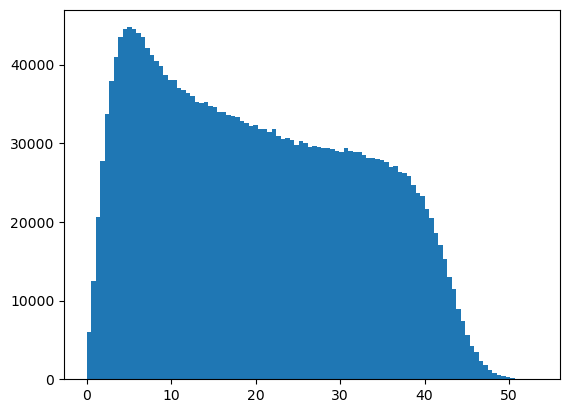

In [30]:
plt.hist((fkde.A_ / fkde.bandwidth).flatten(), bins=100)
plt.show()

In [31]:
# pd.options.display.float_format = "{:.2e}".format
with pd.option_context('display.float_format', '{:.2e}'.format):
    print(sdf[["param_bandwidth", "mean_test_score"]].head())

  param_bandwidth  mean_test_score
0        1.18e-04        -7.13e+06
1        1.48e-04        -4.48e+06
2        1.86e-04        -2.80e+06
3        2.35e-04        -1.77e+06
4        2.95e-04        -1.11e+06
